# Optimization using the ProblemInterface class

This notebook will show the basics of setting up a resilience optimization problem with the `Problem` class in `fmdtools.sim.search` module.

In [20]:
import fmdtools.analyze as an
from pump_stochastic import Pump

### Problem Setup
The `search` module can be used to define an optimization problem around and fmdtools model/simulation in terms of variables, objectives, and constraints.

Different classes enable the optimization of faults, disturbances, and parameters. Below we define a `DisturbanceProblem`, which will optimize the `s.eff` state in the `move_water` function at time `t=20`

In [21]:
from fmdtools.sim.search import DisturbanceProblem
mdl=Pump()
new_problem = DisturbanceProblem(mdl, 20, "move_water.r.s.eff", faultseq={14: {"import_water": "less_wat"}})

In this case, we are optimizing the total flow in the `MoveWater` function as read at time t=25. 

In [22]:
new_problem.add_result_objective("f1", "move_water.s.total_flow", time=25, negative=True)

We can additionally add constraints to the problem, in this case pressure as read at t=25.

In [23]:
new_problem.add_result_constraint('g1', "wat_1.s.pressure", time=25, threshold=20, comparator='less', negative=True)

Note that if all objectives and constraints are sampled in time before the defined simulation end-point, it will finish before completion to save computational time.


In [24]:
new_problem

DisturbanceProblem with:
VARIABLES
 -move_water.r.s.eff                                            nan
OBJECTIVES
 -f1                                                            nan
CONSTRAINTS
 -g1                                                            nan

The string representation of the problem shows how the objectives/constraints have been set up, that reflects:
- the form of the objectives as positive or negative for maximization/minimization (set with the `metric` parameter in `add_objective`).
- the form of the constraints as positive or negative based on the `threshold` parameter in `add_constraint` and overall `negative` kwargs.

These parameters will need to be adjusted depending on whether the interfacing optimization package is set up for minimization or maximization or in positive or negative null form (where feasible means positive or negative constraint values).

### Problem interfaces
Now that this problem is set up, we now have interfaces which can be passed to optimization methods. These are methods which *match the names of the objectives/constraints defined earlier* which can be passed as callables to optimizaiton methods.

In [25]:
new_problem.f1(1)
new_problem.f1(0.5)
new_problem.f1(1.5)
new_problem.f1(2)
new_problem.f1(0.3)

-7.02

Note that despite being different callables, to reduce simulation costs, `obj_1` and `con_1` only *simulate the model* when a new variable value is entered into the problem. This can be seen by looking at the `current_iter` __repr__, which shows the values of the objectives/constraints a the current variable value.

In [26]:
new_problem

DisturbanceProblem with:
VARIABLES
 -move_water.r.s.eff                                         0.3000
OBJECTIVES
 -f1                                                        -7.0200
CONSTRAINTS
 -g1                                                        18.5000

Additionally, we can look at the `iter_hist` iteration history for the problem.

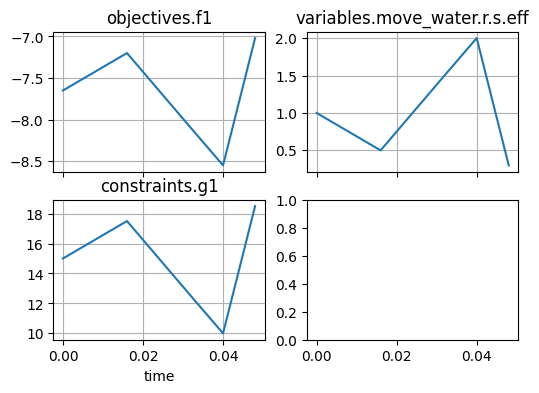

In [27]:
fig, ax = new_problem.iter_hist.plot_line('objectives.f1', 'variables.move_water.r.s.eff',
                                          'constraints.g1')

As well as the actual history of the sim at the current variable value:

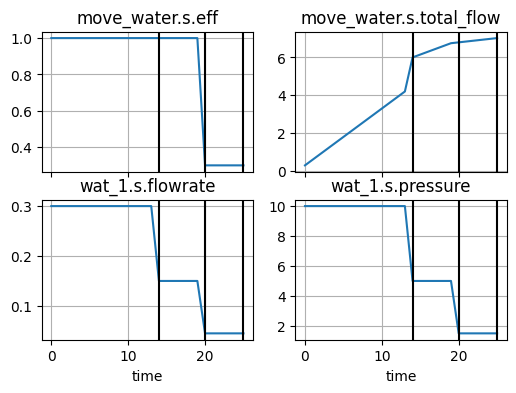

In [28]:
fig, ax = new_problem.hist.plot_line('move_water.s.eff', 'move_water.s.total_flow', 'wat_1.s.flowrate', 'wat_1.s.pressure',
                                     time_slice=[14, 20, 25])

### Optimization:
Now, we will demonstrate optimization using this problem as it is set up:

In [29]:
from scipy.optimize import minimize

In [30]:
con_list = [{'type': 'ineq', 'fun':getattr(new_problem, con)} for con in new_problem.constraints]

Note that scipy minimize assumes that:
- objectives are to be minimized, and
- constraints must be held positive 

The problem should thus be set up to accomodate this, by adjusting whether `negative=True` is sent to `add_result_objective` or `add_result_constraint`/

In [31]:
res = minimize(new_problem.f1, [1], constraints=con_list)

In [32]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -10.349999999999998
       x: [ 4.000e+00]
     nit: 3
     jac: [-9.000e-01]
    nfev: 6
    njev: 3

As shown, the variables are optimized to a value of x=4.0, the maximum possible value of MoveWater.eff which was put in the problem. We can further verify the optimized result by looking at the problem:

In [33]:
new_problem

DisturbanceProblem with:
VARIABLES
 -move_water.r.s.eff                                         4.0000
OBJECTIVES
 -f1                                                       -10.3500
CONSTRAINTS
 -g1                                                        -0.0000

As shown, the bound set constraint x>0 is active at the found minimum, as we would expect.

We can further visualize this solution using:

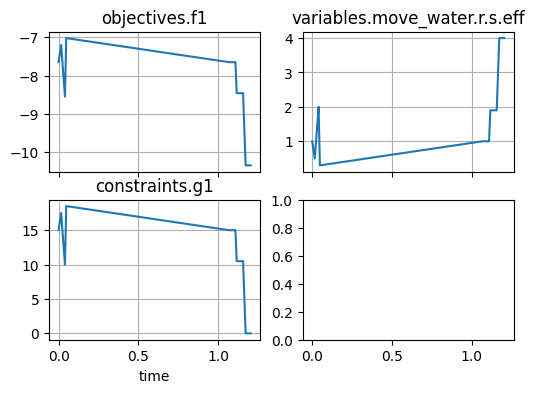

In [35]:
fig, ax = new_problem.iter_hist.plot_line('objectives.f1', 'variables.move_water.r.s.eff',
                                          'constraints.g1')

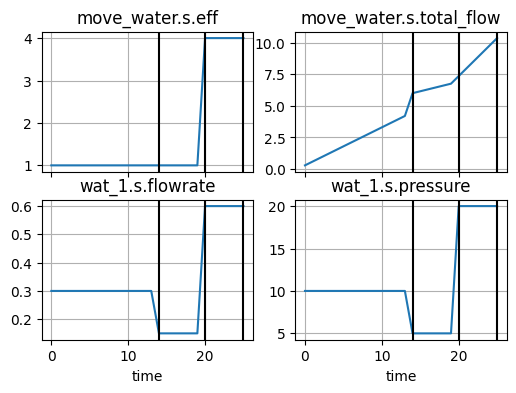

In [36]:
fig, ax = new_problem.hist.plot_line('move_water.s.eff', 'move_water.s.total_flow', 'wat_1.s.flowrate', 'wat_1.s.pressure',
                                     time_slice=[14, 20, 25])

As shown, the constraint `g1` is active, meaning the optimal presure at `t=20` is just at the threshold of 20. This corresponds to the optimized `MoveWater.eff` value of 4.0.

In [45]:
assert abs(new_problem.constraints['g1'].value) < 0.001
assert abs(new_problem.variables['move_water.r.s.eff'] - 4.0)  < 0.001

### Multi-scenario Optimization

In addition to optimizing over single-scenarios `Problem` can be used to optimize over lists of scenarios from an `SampleApproach` or `NominalApproach`.

Here we define a slightly different problem, where instead of optimizing variable changes at specific times (e.g., faults), we instead optimize the model parameter `delay`, which changes how long of a delay there is before a fault when there is adverse pressure.

To see the effect of this accross scenarios, we first define an approach:

In [ ]:
app = SampleApproach(mdl, faults="export_water", phases=["on"], defaultsamp={'samp':'evenspacing','numpts':4})

In [ ]:
app

The scenlist from this approach is given to the same model.

In [ ]:
multi_problem = ProblemInterface("multi_problem", mdl, negative_form=False) #, track='valparams')
multi_problem.add_simulation("test_multi", "multi", app.scenlist)

Next the delay parameter is added. Note that since this a model parameter (set at the beginning of the simulation), `vartype` is set to "param".

In [ ]:
multi_problem.add_variables("test_multi", ("delay", [0,45]), vartype='param')

Our objective for this problem will be to minimize the cost model overall scenarios that is defined in `mdl.find_classification`. Note that this means `objtype` must be set to "endclass", since the objective will be a value of the endclass dictionary corresponding to the key "expected cost".

In [ ]:
multi_problem.add_objectives("test_multi", cost="expected cost", objtype='endclass')

We can then verify the problem setup. Note that no constraints will be used in this problem:

In [ ]:
multi_problem

We may now minimize the objective function:

In [ ]:
res = minimize(multi_problem.cost, [5], method="SLSQP", bounds=[[0,40]])

In [ ]:
res = minimize(multi_problem.cost, [5], method="nelder-mead")

In [ ]:
res

Interestingly enough, while the optimizer gives a "optimization terminated successfully," it stays at the initial point. This may be because of a poor fit of oftimization method. See:

In [ ]:
objs = [multi_problem.cost([i]) for i in range(100)]

In [ ]:
plt.plot(objs)
plt.scatter(res.x, res.fun)

As shown, the objective appears to be non-differentiable, with several plateaus between the starting point (20) and the minimum. Since the `SLSQP` solver is a gradient-based solver, it probably sees the gradient as 0 at this point, making it think the result is already an optimum. 

While many different optimization packages exist, one of the more-developed ones is the `pymoo` package ([see reference](https://pymoo.org/)). Below we show how to interface with `pymoo` to use a solver that will find the optimal solution.

In [ ]:
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
import numpy as np

The method `.to_pymoo_problem()` sets up a [pymoo problem object](https://pymoo.org/interface/problem.html) which can be used with a pymoo algorithm per the documentation. Note that this object corresponds directly (that is, is linked) to the original problem (see below).

In [ ]:
pymoo_prob = multi_problem.to_pymoo_problem()

In [ ]:
algorithm=PatternSearch(x0=np.array([5])) 

In [ ]:
res = minimize(pymoo_prob, algorithm, verbose=True)

In [ ]:
res.X

In [ ]:
res.F

In [ ]:
plt.plot(objs)
plt.scatter(res.X, res.F)

As shown, this method more capably finds the minimum in this case, in part because the underlying search algorithm (Hooke and Jeeves Pattern Search) is more robust to this type of problem.

We can visualize the results of this problem by looking at the simulation log:

In [ ]:
fig, ax = an.plot.mdlhists(multi_problem._sims['test_multi']['mdlhists'],\
              fxnflowvals={"MoveWater":['total_flow', "faults"], "Wat_2":{"area", 'flowrate', 'pressure'}},\
              time_slice=app.times, legend_loc=False)

Compare this with the response at the initial value:

In [ ]:
multi_problem.cost([1])
fig, ax = an.plot.mdlhists(multi_problem._sims['test_multi']['mdlhists'],\
              fxnflowvals={"MoveWater":['total_flow', "faults"], "Wat_2":{"area", 'flowrate', 'pressure'}},\
              time_slice=app.times, legend_loc=False)

As shown, the main difference is that at the initial point, the short delay causes the pump to during the time of the simulation, while at a long delay, the pump breaks later in the simulation. The optimum is at t=37 since this is the first point where all four scenarios no longer result in a mechanical break of the pump.